In [4]:
# --- 1. 환경 설정 셀 (수정된 버전) ---
import os
import sys

# 작업 디렉토리를 올바른 위치로 변경
workspace_path = '/workspace'
os.chdir(workspace_path)

# RFdiffusion 경로를 파이썬이 인식하도록 추가
rfdiffusion_path = os.path.join(workspace_path, 'RFdiffusion')
if rfdiffusion_path not in sys.path:
    sys.path.append(rfdiffusion_path)
import time
import signal
import sys
import random
import string
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

# Colab이 아닌 로컬 환경이므로, RFdiffusion 경로를 직접 추가
if 'RFdiffusion' not in sys.path:
    home_dir = os.path.expanduser("~")
    rfdiffusion_path = os.path.join(home_dir, 'RFdiffusion')
    sys.path.append(rfdiffusion_path)

os.environ["DGLBACKEND"] = "pytorch"

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

# --- Colab의 files.upload()를 대체하는 로컬 파일 처리 함수 ---
def get_pdb(pdb_code=None, use_upload=False):
    if use_upload:
        upload_widget = widgets.FileUpload(
            accept='.pdb', description='PDB 파일 업로드', button_style='info'
        )
        display(upload_widget)
        
        def wait_for_upload(widget):
            while len(widget.value) == 0: time.sleep(0.1)
            uploaded_filename = list(widget.value.keys())[0]
            pdb_content = widget.value[uploaded_filename]['content']
            pdb_filename = "tmp.pdb"
            with open(pdb_filename, "wb") as out: out.write(pdb_content)
            print(f"'{uploaded_filename}'이(가) 'tmp.pdb'로 저장되었습니다.")
            return pdb_filename
            
        return wait_for_upload(upload_widget)
    elif pdb_code is None or pdb_code == "":
        print("PDB 코드를 입력하거나 use_upload=True로 설정하세요.")
        return None
    elif os.path.isfile(pdb_code): return pdb_code
    elif len(pdb_code) == 4:
        pdb_filename = f"{pdb_code}.pdb1"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz && gunzip -f {pdb_code}.pdb1.gz")
        return pdb_filename
    else:
        pdb_filename = f"AF-{pdb_code}-F1-model_v4.pdb"
        if not os.path.isfile(pdb_filename):
            os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/{pdb_filename}")
        return pdb_filename

def run_ananas(pdb_str, path, sym=None):
    pdb_filename = f"outputs/{path}/ananas_input.pdb"
    out_filename = f"outputs/{path}/ananas.json"
    os.makedirs(f"outputs/{path}", exist_ok=True)
    with open(pdb_filename,"w") as handle: handle.write(pdb_str)
    cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
    if sym is None: os.system(cmd)
    else: os.system(f"{cmd} {sym}")
    try:
        with open(out_filename,"r") as f: out = json.load(f)
        results, AU = out[0], out[-1]["AU"]
        group, chains, rmsd = AU["group"], AU["chain names"], results["Average_RMSD"]
        print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")
        C = np.array(results['transforms'][0]['CENTER'])
        A = [np.array(t["AXIS"]) for t in results['transforms']]
        new_lines = []
        for line in pdb_str.split("\n"):
            if line.startswith("ATOM"):
                chain = line[21:22]
                if chain in chains:
                    x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
                    if group[0] == "c": x = sym_it(x,C,A[0])
                    if group[0] == "d": x = sym_it(x,C,A[1],A[0])
                    coord_str = "".join([f"{a:8.3f}" for a in x])
                    new_lines.append(line[:30]+coord_str+line[54:])
            else: new_lines.append(line)
        return results, "\n".join(new_lines)
    except Exception as e:
        print(f"AnAnaS 결과 처리 중 오류 발생: {e}")
        return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):
    def run_command_and_get_pid(command):
        pid_file = '/dev/shm/pid'
        os.system(f'nohup {command} > /dev/null & echo $! > {pid_file}')
        with open(pid_file, 'r') as f: pid = int(f.read().strip())
        os.remove(pid_file)
        return pid
    def is_process_running(pid):
        try: os.kill(pid, 0)
        except OSError: return False
        else: return True
    run_output = widgets.Output()
    progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
    display(widgets.VBox([progress, run_output]))
    for n in range(steps):
        if os.path.isfile(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
    pid = run_command_and_get_pid(command)
    try:
        fail = False
        for _ in range(num_designs):
            for n in range(steps):
                wait = True
                while wait and not fail:
                    time.sleep(0.1)
                    if os.path.isfile(f"/dev/shm/{n}.pdb"):
                        with open(f"/dev/shm/{n}.pdb", "r") as f: pdb_str = f.read()
                        if "TER" in pdb_str or "ENDMDL" in pdb_str: wait = False
                        elif not is_process_running(pid): fail = True
                    elif not is_process_running(pid): fail = True
                if fail:
                    progress.bar_style = 'danger'; progress.description = "failed"
                    break
                else:
                    progress.value = (n+1) / steps
                    if visual != "none":
                        with run_output:
                            run_output.clear_output(wait=True)
                            if visual == "image":
                                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                                fig = plt.figure(); fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1); plt.show()
                            if visual == "interactive":
                                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                                view.addModel(pdb_str,'pdb'); view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                                view.zoomTo(); view.show()
                if os.path.exists(f"/dev/shm/{n}.pdb"): os.remove(f"/dev/shm/{n}.pdb")
            if fail:
                progress.bar_style = 'danger'; progress.description = "failed"
                break
        while is_process_running(pid): time.sleep(0.1)
    except KeyboardInterrupt:
        os.kill(pid, signal.SIGTERM); progress.bar_style = 'danger'; progress.description = "stopped"
    
def run_diffusion(contigs, path, pdb=None, iterations=50, symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, num_designs=1, visual="none"):
    full_path = f"outputs/{path}"; os.makedirs(full_path, exist_ok=True)
    opts = [f"inference.output_prefix={full_path}", f"inference.num_designs={num_designs}"]
        # --- 👇 여기 이 한 줄을 추가하세요! ---
    opts.append(f"+inference.schedule_directory_path={full_path}/schedules")
    # ---
    if chains == "": chains = None
    if symmetry in ["auto","cyclic","dihedral"]:
        if symmetry == "auto": sym, copies = None, 1
        else: sym, copies = {"cyclic":(f"c{order}",order), "dihedral":(f"d{order}",order*2)}[symmetry]
    else: symmetry = None; sym, copies = None, 1
    contigs_list = contigs.replace(","," ").replace(":"," ").split()
    is_fixed, is_free = False, False; fixed_chains = []
    for contig in contigs_list:
        for x in contig.split("/"):
            a = x.split("-")[0]
            if a and a[0].isalpha():
                is_fixed = True
                if a[0] not in fixed_chains: fixed_chains.append(a[0])
            if a.isnumeric(): is_free = True
    if len(contigs_list) == 0 or not is_free: mode = "partial"
    elif is_fixed: mode = "fixed"
    else: mode = "free"
    if mode in ["partial","fixed"]:
        pdb_str = pdb_to_string(pdb, chains=chains)
        if symmetry == "auto":
            a, pdb_str = run_ananas(pdb_str, path)
            if a is None: print(f'ERROR: no symmetry detected'); symmetry = None; sym, copies = None, 1
            else:
                if a["group"][0] == "c": symmetry = "cyclic"; sym, copies = a["group"], int(a["group"][1:])
                elif a["group"][0] == "d": symmetry = "dihedral"; sym, copies = a["group"], 2 * int(a["group"][1:])
                else: print(f'ERROR: detected symm ({a["group"]}) not supported'); symmetry = None; sym, copies = None, 1
        elif mode == "fixed": pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)
        pdb_filename = f"{full_path}/input.pdb"
        with open(pdb_filename, "w") as handle: handle.write(pdb_str)
        parsed_pdb = parse_pdb(pdb_filename)
        opts.append(f"inference.input_pdb={pdb_filename}")
        if mode in ["partial"]:
            iterations = int(80 * (iterations / 200)); opts.append(f"diffuser.partial_T={iterations}")
            contigs_list = fix_partial_contigs(contigs_list, parsed_pdb)
        else: opts.append(f"diffuser.T={iterations}"); contigs_list = fix_contigs(contigs_list, parsed_pdb)
    else:
        opts.append(f"diffuser.T={iterations}"); parsed_pdb = None
        contigs_list = fix_contigs(contigs_list, parsed_pdb)
    if hotspot is not None and hotspot != "": opts.append(f"ppi.hotspot_res=[{hotspot}]")
    if sym is not None:
        sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
        if add_potential: sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'", "potentials.olig_intra_all=True","potentials.olig_inter_all=True", "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
        opts = sym_opts + opts; contigs_list = sum([contigs_list] * copies,[])
    opts.append(f"'contigmap.contigs=[{' '.join(contigs_list)}]'")
    opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
    print("mode:", mode); print("output:", full_path); print("contigs:", contigs_list)
    run_script_path = "/workspace/RFdiffusion/run_inference.py"
    opts_str = " ".join(opts)
    cmd = f"python {run_script_path} {opts_str}"
    print(cmd)
    run(cmd, iterations, num_designs, visual=visual)
    for n in range(num_designs):
        pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb", f"outputs/traj/{path}_{n}_Xt-1_traj.pdb", f"{full_path}_{n}.pdb"]
        for pdb_file in pdbs:
            if os.path.exists(pdb_file):
                with open(pdb_file,"r") as handle: pdb_str = handle.read()
                with open(pdb_file,"w") as handle: handle.write(fix_pdb(pdb_str, contigs_list))
    return contigs_list, copies

print("✅ Setup cell is ready.")

✅ Setup cell is ready.


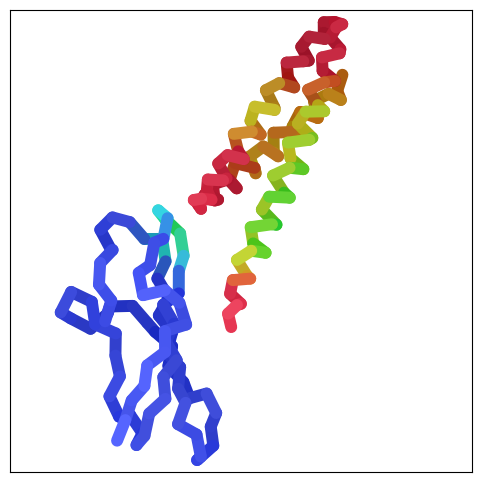

In [ ]:
# --- 2번 셀: 바인더 디자인 실행 (경로 단순화 버전) ---

# 1. 파라미터 설정
name = "0908-150-600sc"
contigs = "C311-391/0 100-100"
hotspot = "C331,C360,C378,C381,C323"
iterations = 150
num_designs = 600 # 필요에 따라 늘리세요
visual = "image"

# 2. PDB 파일 경로 지정
pdb_filename = "4k9e_c.pdb" 
pdb = os.path.join("/workspace", pdb_filename)

# 3. RFdiffusion 실행
# 기본 실행 이름(폴더명으로 사용될)을 설정합니다.
base_name = name
output_dir = f"outputs/{base_name}"

# 만약 동일한 이름의 폴더가 이미 존재하면, 중복을 피하기 위해 랜덤 문자열을 뒤에 붙입니다.
while os.path.exists(output_dir):
    random_suffix = ''.join(random.choices(string.ascii_lowercase + string.digits, k=4))
    base_name = f"{name}_{random_suffix}"
    output_dir = f"outputs/{base_name}"

# ✨ 경로 구조를 'outputs/실행이름'으로 단순화했습니다.
# run_diffusion 함수는 이 base_name을 사용합니다.
path = base_name 
print(f"✅ 결과가 저장될 폴더: {output_dir}")

flags = {
    "contigs": contigs, "pdb": pdb, "iterations": int(iterations),
    "hotspot": hotspot, "path": path, "num_designs": int(num_designs),
    "visual": visual, "symmetry": "none", "order": 1, "chains": "", "add_potential": True
}

for k, v in flags.items():
    if isinstance(v, str):
        flags[k] = v.replace("'", "").replace('"', '')

# run_diffusion 함수 내에서 output_prefix가 'outputs/{path}'로 설정됩니다.
# 최종 결과는 'outputs/{path}_{디자인번호}.pdb' 형식으로 저장됩니다.
contigs_list, copies = run_diffusion(**flags)

# --- 마지막 출력 메시지 ---
print(f"✅ RFdiffusion 실행 완료! 결과는 '{output_dir}' 폴더에 저장되었습니다.")
print(f"   다음 셀에서 'run_name'에 '{base_name}' 을(를) 입력하세요.")

In [8]:
%%time
# --- 3번 셀: ProteinMPNN 및 AlphaFold2 검증 (최종 통합 버전) ---
import os
import sys
import pandas as pd
import glob
import re
import subprocess
import io

# @markdown ### **👇 여기에 이전 실행 정보를 입력하세요.**
# @markdown ---

# <<< (1) 2번 셀 실행 후 출력된 `run_name`을 입력하세요. (예: "0904-binder-design")
run_name = "0906-150-600sc"  # @param {type:"string"}

# <<< (2) 위 백본 생성에 사용했던 '원본' Contig를 입력하세요.
contigs_for_run = "C311-391/0 100-100"  # @param {type:"string"}

# @markdown ---
# @markdown ### **MPNN 및 AlphaFold 설정**
num_seqs = 8      #@param {type:"raw"}
num_recycles = 3  #@param {type:"raw"}
initial_guess = True
use_multimer = True
rm_aa = "C"
mpnn_sampling_temp = 0.1

# --- 아래는 수정할 필요 없이 그대로 실행하면 됩니다. ---

# (A) 실행 경로 설정
output_dir = f"outputs/{run_name}"
pdb_path_pattern = f"{output_dir}_*.pdb"
pdb_files = glob.glob(pdb_path_pattern)
num_designs = len(pdb_files)

if num_designs == 0:
    print(f"🚨 에러: '{output_dir}' 폴더에서 PDB 파일을 찾을 수 없습니다. 'run_name'을 확인해주세요.")
else:
    print(f"✅ 총 {num_designs}개의 PDB 파일을 찾았습니다. 검증 작업을 시작합니다.")
    
    # (B) 수동 입력 Contig를 ColabDesign 규칙에 맞게 자동 변환
    print("\n🔄 ProteinMPNN에 사용할 Contig 정보를 자동 변환합니다...")
    mpnn_contigs_list = []
    chain_code = ord('A')
    
    for segment in contigs_for_run.split('/0'):
        sub_part = segment.strip()
        if not sub_part: continue
        
        # 원본에 체인 문자가 있었던 scaffold 부분만 새 체인 ID를 부여
        if sub_part[0].isalpha():
            chain = chr(chain_code)
            match = re.match(r'[A-Z](\d+)-(\d+)', sub_part)
            start, end = int(match.group(1)), int(match.group(2))
            length = end - start + 1
            mpnn_contigs_list.append(f'{chain}1-{length}')
            chain_code += 1
        
        # 체인 문자가 없던 binder 부분은 그대로 사용
        elif sub_part[0].isdigit():
            mpnn_contigs_list.append(sub_part)

    contigs_str = ":".join(mpnn_contigs_list)
    print(f"   - ✨ 최종 변환된 Contig: {contigs_str}\n")
    
    # --- (C) designability_test 스크립트 실행 및 결과 직접 파싱 ---
    opts = [f"--pdb={output_dir}_0.pdb",
            f"--loc={output_dir}",
            f"--contig={contigs_str}",
            f"--copies=1",
            f"--num_seqs={num_seqs}",
            f"--num_recycles={num_recycles}",
            f"--rm_aa={rm_aa}",
            f"--mpnn_sampling_temp={mpnn_sampling_temp}",
            f"--num_designs={num_designs}"]
    if initial_guess: opts.append("--initial_guess")
    if use_multimer: opts.append("--use_multimer")
    opts_str = ' '.join(opts)

    # ✨ subprocess를 사용해 실행하고 결과를 직접 변수에 저장합니다.
    print(f"Running command: python -m colabdesign.rf.designability_test {opts_str}")
    result = subprocess.run(f"python -m colabdesign.rf.designability_test {opts_str}", shell=True, capture_output=True, text=True)
    print("Done.")

    # stdout (화면 출력) 내용을 분석합니다.
    stdout_lines = result.stdout.splitlines()

    all_results_data = []
    for line in stdout_lines:
        if line.startswith("design:"):
            try:
                parts = line.split()
                data = {
                    'design': int(parts[0].split(':')[1]),
                    'n': int(parts[1].split(':')[1]),
                    'mpnn': float(parts[2].split(':')[1]),
                    'plddt': float(parts[3].split(':')[1]),
                    'ptm': float(parts[4].split(':')[1]),
                    'pae': float(parts[5].split(':')[1]),
                    'rmsd': float(parts[6].split(':')[1]),
                    'sequence': parts[7]
                }
                all_results_data.append(data)
            except (IndexError, ValueError) as e:
                print(f"Warning: Could not parse line: {line} due to {e}")

    # --- (D) 결과 요약 출력 ---
    print("\n----------------------------------------------------")
    if not all_results_data:
        print("⚠️ 스크립트 출력에서 유효한 결과 데이터를 찾을 수 없었습니다.")
        # 디버깅을 위해 에러 로그 출력
        if result.stderr:
            print("\n--- Error Log ---")
            print(result.stderr)
    else:
        print("📊 전체 디자인 결과 요약:")
        df = pd.DataFrame(all_results_data)
        
        # 생성된 데이터프레임으로 CSV 파일 저장
        generated_csv_path = os.path.join(output_dir, "all_results_parsed.csv")
        df.to_csv(generated_csv_path, index=False)
        print(f"   (결과가 '{generated_csv_path}'에 저장되었습니다)")
        
        if not df.empty:
            print(df[['design', 'n', 'plddt', 'rmsd', 'sequence']].to_string(index=False))
            best_model_info = df.sort_values(by='plddt', ascending=False).iloc[0]
            design_num = int(best_model_info['design'])
            seq_num = int(best_model_info['n'])
            plddt_val = best_model_info['plddt']
            
            print("\n🏆 Best 모델 (pLDDT 기준):")
            print(f"   - 모델 번호: design {design_num} / sequence {seq_num}")
            print(f"   - pLDDT 값: {plddt_val:.2f}")

🚨 에러: 'outputs/0906-150-600sc' 폴더에서 PDB 파일을 찾을 수 없습니다. 'run_name'을 확인해주세요.
CPU times: user 3.04 ms, sys: 0 ns, total: 3.04 ms
Wall time: 2.06 ms


In [19]:
# --- 4번 셀: Top N 디자인 선별 및 PDB 파일 저장 ---

import pandas as pd
import os
import shutil

# @markdown ### **👇 분석할 실행 정보와 필터링 조건을 입력하세요.**
# @markdown ---

# <<< (1) 3번 셀에서 사용했던 `run_name`을 정확히 입력하세요.
run_name = "0908-150-600sc"  # @param {type:"string"}

# <<< (2) 몇 개의 상위 디자인을 선별할지 숫자를 입력하세요.
top_n = 20  # @param {type:"integer"}

# <<< (3) PAE 점수 필터링 기준값을 입력하세요. (낮을수록 좋음)
pae_threshold = 15.0  # @param {type:"number"}

# --- 아래는 수정할 필요 없이 그대로 실행하면 됩니다. ---

# 1. 결과 파일 및 경로 설정
output_dir = f"outputs/{run_name}"
# ✨ 3번 셀에서 생성된 우리 결과 파일을 사용합니다.
results_csv_path = os.path.join(output_dir, "all_results_parsed.csv") 
ranked_pdb_folder = os.path.join(output_dir, f"ranked_top_{top_n}")

print(f"'{results_csv_path}' 파일에서 결과 분석을 시작합니다.")

# 2. 결과 파일이 있는지 확인
if not os.path.exists(results_csv_path):
    print(f"🚨 에러: 결과 파일({results_csv_path})을 찾을 수 없습니다. run_name을 확인하거나 3번 셀을 먼저 실행하세요.")
else:
    # 3. CSV 파일 읽어오기
    df_all = pd.read_csv(results_csv_path)
    
    # 4. PAE 점수 조건으로 필터링
    # ✨ 'i_pae' 대신 우리 결과 파일에 있는 'pae' 컬럼을 사용합니다.
    if 'pae' in df_all.columns:
        df_filtered = df_all[df_all['pae'] < pae_threshold].copy()
        print(f"PAE < {pae_threshold} 조건을 만족하는 디자인 {len(df_filtered)}개를 찾았습니다.")
    else:
        print("⚠️ 경고: 'pae' 컬럼을 찾을 수 없습니다. 필터링 없이 진행합니다.")
        df_filtered = df_all.copy()

    # 5. RMSD 기준으로 오름차순 정렬 (낮을수록 좋음)
    df_sorted = df_filtered.sort_values(by='rmsd', ascending=True)

    # 6. 상위 N개 디자인 선택
    top_designs = df_sorted.head(top_n)
    print(f"RMSD가 낮은 순서대로 상위 {len(top_designs)}개를 선별했습니다.")

    # 7. 순위별 PDB 파일을 저장할 폴더 생성
    os.makedirs(ranked_pdb_folder, exist_ok=True)
    print(f"선별된 PDB 파일은 '{ranked_pdb_folder}' 폴더에 저장됩니다.")

    # 8. PDB 파일 복사 및 이름 변경
    copied_count = 0
    for rank, (index, row) in enumerate(top_designs.iterrows(), 1):
        design_num = int(row['design'])
        seq_num = int(row['n'])
        
        # ✨ ColabDesign이 생성한 최종 PDB 파일명 형식에 맞게 경로를 지정합니다.
        source_pdb_file = os.path.join(output_dir, f"design_{design_num}_n{seq_num}.pdb")
        
        # 순위와 주요 점수를 포함한 새로운 파일명 지정
        rmsd_val = row['rmsd']
        plddt_val = row['plddt']
        dest_pdb_file = os.path.join(ranked_pdb_folder, f"rank_{rank:03d}_design{design_num}n{seq_num}_plddt{plddt_val:.2f}_rmsd{rmsd_val:.2f}.pdb")

        if os.path.exists(source_pdb_file):
            shutil.copy(source_pdb_file, dest_pdb_file)
            copied_count += 1
        else:
            # ✨ designability_test 스크립트는 모든 PDB를 저장하지 않을 수 있으므로, 파일이 없는 경우는 일반적인 경고로 처리합니다.
            # print(f"   - 정보: 원본 파일 '{source_pdb_file}'은(는) 생성되지 않아 건너뜁니다.")
            pass

    print(f"\n✅ 작업 완료: 총 {copied_count}개의 PDB 파일을 순위별로 저장했습니다.")
    
    # 9. 선별된 디자인의 통계 정보 출력
    # ✨ 우리 결과 파일에 있는 컬럼 이름('pae')으로 수정합니다.
    print(f"\n📊 선별된 Top {len(top_designs)} 디자인 목록:")
    print(top_designs[['design', 'n', 'plddt', 'pae', 'rmsd']].to_string(index=False))

'outputs/0908-150-600sc/all_results_parsed.csv' 파일에서 결과 분석을 시작합니다.
PAE < 15.0 조건을 만족하는 디자인 34개를 찾았습니다.
RMSD가 낮은 순서대로 상위 20개를 선별했습니다.
선별된 PDB 파일은 'outputs/0908-150-600sc/ranked_top_20' 폴더에 저장됩니다.

✅ 작업 완료: 총 0개의 PDB 파일을 순위별로 저장했습니다.

📊 선별된 Top 20 디자인 목록:
 design  n  plddt    pae  rmsd
    151  1  0.890 11.076 2.166
    103  4  0.844 14.545 2.344
    163  4  0.934  8.868 2.415
    163  2  0.892  9.178 2.711
    163  1  0.931  7.881 2.840
    163  5  0.930  9.948 2.913
    452  0  0.809 13.602 3.119
    163  7  0.922 10.174 3.196
    163  6  0.936  8.269 3.204
    103  0  0.831 10.422 3.259
    195  3  0.900  8.125 3.347
    103  5  0.866  8.429 3.870
    360  5  0.878 14.741 4.019
    394  4  0.928  8.841 4.140
    156  2  0.869 12.824 5.206
    156  0  0.898 11.494 5.515
    156  6  0.867 13.373 5.675
    156  1  0.865 12.426 6.427
    156  3  0.888 12.793 6.522
    156  5  0.890 10.699 6.851
